In [1]:
!pip install -q utils
!pip install -q mxnet

     |████████████████████████████████| 68.7MB 56kB/s 


In [0]:
from utils import *

import time
import numpy as np

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA


import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
from sklearn import decomposition
pca = decomposition.PCA()

In [0]:
import warnings
warnings.filterwarnings("ignore")
context = mx.cpu(); model_ctx=mx.cpu()
mx.random.seed(1719)
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')
    

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/gs.csv \
    -O /tmp/gs.csv

--2020-03-23 14:14:05--  https://raw.githubusercontent.com/Karunanidhimishra/dataset/master/gs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231285 (226K) [text/plain]
Saving to: ‘/tmp/gs.csv’

/tmp/gs.csv         100%[===================>] 225.86K  --.-KB/s    in 0.03s   

2020-03-23 14:14:06 (7.99 MB/s) - ‘/tmp/gs.csv’ saved [231285/231285]



In [0]:
dataset_ex_df = pd.read_csv('/tmp/gs.csv', header=0, parse_dates=[0], date_parser=parser)

In [0]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    dataset['20std'] = dataset['Close'].rolling(window=20).std()
    
    # Create MACD
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    #dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20std']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20std']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
   
    return dataset

In [16]:
dataset_TI_df = get_technical_indicators(dataset_ex_df[['Close']])
dataset_TI_df.tail()

,Close,ma7,ma21,20std,26ema,12ema,MACD,upper_band,lower_band,ema,momentum
4656,243.49,243.444286,242.185238,2.408399,240.727156,243.093392,2.366236,247.002035,237.368441,243.944580,242.49
4657,239.81,243.172857,242.042857,2.461453,240.659218,242.588255,1.929037,246.965764,237.119950,241.188193,238.81
4658,241.25,243.224286,241.978571,2.465415,240.702980,242.382370,1.679390,246.909402,237.047741,241.229398,240.25
4659,240.79,242.982857,241.901905,2.429494,240.709426,242.137390,1.427964,246.760894,237.042916,240.936466,239.79
4660,240.15,242.395714,241.918571,2.332540,240.667987,241.831637,1.163650,246.583652,237.253491,240.412155,239.15


In [0]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [9]:
#Statistical Checks
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing

#Standardization
sample_data=dataset_TI_df.fillna(0)
standardized_data = StandardScaler().fit_transform(sample_data)
standardized_data = pd.DataFrame(data=standardized_data,columns=sample_data.columns)

#MultiCollearity Check
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(standardized_data.values, i) for i in range(standardized_data.shape[1])]
vif["features"] = standardized_data.columns
print(vif.round(1))

(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(standardized_data)

#Regression Table
est=sm.OLS(y_train_FI, X_train_FI)
est = est.fit()
est.summary()

    VIF Factor    features
0          inf       Close
1        491.6         ma7
2          inf        ma21
3       4864.0       20std
4          inf       26ema
5          inf       12ema
6          inf        MACD
7          inf  upper_band
8          inf  lower_band
9       7399.0         ema
10         inf    momentum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.043e+31
Date:                Mon, 23 Mar 2020   Prob (F-statistic):                        0.00
Time:                        14:14:08   Log-Likelihood:                          95072.
No. Observations:                3029   AIC:                                 -1.901e+05
Df Residuals:                    3021   BIC:                                 -1.901e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ma7         1.473e-16   1.91e-15      0.077      0.939   -3.61e-15     3.9e-15
ma21       -8.138e-16   1.13e-15     -0.723      0.470   -3.02e-15    1.39e-15
20std       2.906e-15   5.79e-15      0.501      0.616   -8.46e-15    1.43e-14
26ema      -4.982e-16   1.49e-15     -0.335      0.737   -3.41e-15    2.42e-15
12ema       1.241e-16   1.49e-15      0.084      0.933   -2.79e-15    3.04e-15
MACD        2.156e-15    2.4e-16      8.998      0.000    1.69e-15    2.63e-15
upper_band -1.422e-15   2.86e-14     -0.050      0.960   -5.75e-14    5.46e-14
lower_band -2.645e-15   2.82e-14     -0.094      0.925   -5.79e-14    5.26e-14
ema         5.616e-16   8.37e-15      0.067      0.947   -1.59e-14     1.7e-14
momentum       1.0000   6.53e-15   1.53e+14      0.000       1.000       1.000
==============================================================================
Omnibus:                       16.278   Durbin-Watson:                   0.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.237
Skew:                           0.166   Prob(JB):                     0.000298
Kurtosis:                       2.864   Cond. No.                     2.82e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.77e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [0]:
params={'colsample_bytree': 0.5,
 'eval_metric': 'rmse',
 'gamma': 5,
 'learning_rate': 0.005006883383023541,
 'max_depth': 9,
 'min_child_weight': 10,
 'n_estimators': 193,
 'optimizer': 'MomentumSGD',
 'scale_pos_weight': 41,
 'objective' :'reg:linear',
 'subsample': 0.9}

[15:18:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 0.467364


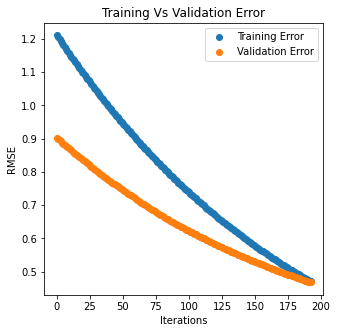

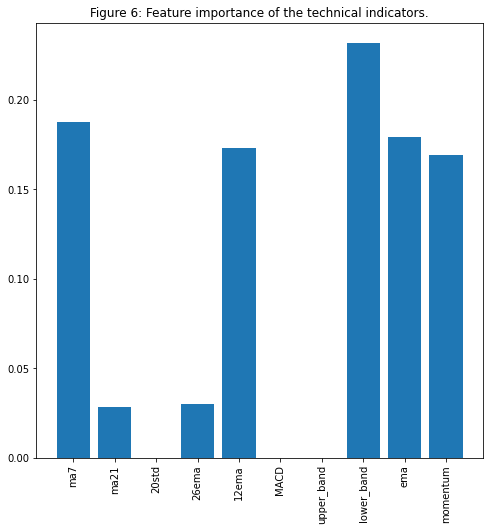

In [18]:
#regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)
regressor = xgb.XGBRegressor(**params)
xgbModel = regressor.fit(X_train_FI,y_train_FI, \
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)], \
                         verbose=False)
preds = regressor.predict(X_test_FI)
rmse = np.sqrt(mean_squared_error(y_test_FI, preds))
print("RMSE: %f" % (rmse))
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

#validation graph
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

#Bar graph
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

[16:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:38:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
74    0.840327
Name: test-rmse-mean, dtype: float64


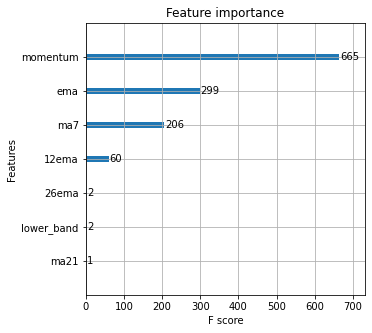

In [22]:
#Using K-Fold Cross-Validation
data_dmatrix = xgb.DMatrix(data=X_train_FI,label=y_train_FI)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=75,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)
print((cv_results["test-rmse-mean"]).tail(1))

#Plot_Features
xgb.plot_importance(regressor)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()


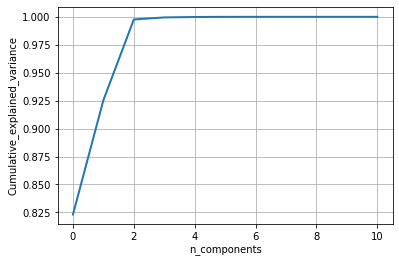

   1st_principal  2nd_principal
0      -6.016355      -0.923317
1      -6.046409      -0.913815
2      -6.076680      -0.900453
3      -5.953635      -0.963161
4      -6.002770      -0.949053
shape of pca_reduced.shape =  (4661, 2)


In [13]:
#PCA for dimensionality Reduction
pca.n_components = standardized_data.shape[1]
pca_data = pca.fit_transform(standardized_data)
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);
cum_var_explained = np.cumsum(percentage_var_explained)

# Plot the PCA spectrum
plt.figure(1, figsize=(6, 4))
plt.clf()
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Cumulative_explained_variance')
plt.show()

#Reduced Dimension
pca.n_components = 2
pca_data = pca.fit_transform(standardized_data)
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal"))
print(pca_df.head())
# pca_reduced will contain the 2-d projects of simple data
print("shape of pca_reduced.shape = ", pca_data.shape)
